# 🧠 Model Training

## Importaciones

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tqdm import tqdm
from tensorflow import keras

## Obtención de datos

**Fuente:** [dataset_vectorized.csv](https://raw.githubusercontent.com/Latency-Zero-tfm/HardVisionAI/refs/heads/main/data/processed/dataset_vectorized.csv)

Utilizaremos nuestro dataset resultante del web scraping de distintas páginas, ya procesado y listo para usar en nuestro modelo.


In [29]:
df = pd.read_csv('../data/processed/components_03.csv')

In [30]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   local_image_path  9971 non-null   str  
 1   label             9971 non-null   int64
dtypes: int64(1), str(1)
memory usage: 155.9 KB


## Mezcla de datos

In [31]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,local_image_path,label
0,../data/images/ram_3356.jpg,4
1,../data/images/hard_drive_2406.jpg,3
2,../data/images/ram_4376.jpg,4
3,../data/images/motherboard_107.jpg,0
4,../data/images/cpu_9398.jpg,2
...,...,...
9966,../data/images/pc_case_5739.jpg,5
9967,../data/images/pc_case_5195.jpg,5
9968,../data/images/pc_case_5395.jpg,5
9969,../data/images/gpu_861.jpg,1


## Procesamiento de imágenes

### Procesamiento y vectorización de imágenes

En este paso, redimensionamos las imágenes a una proporción estándar y las convertimos en vectores numéricos, lo que permite su posterior análisis y uso en nuestro futuro modelo.

In [32]:
def preparar_dataset_alineado(df, directorio_imagenes, columna_archivo, ancho=270, alto=270):
    """
    Carga imágenes en el orden exacto especificado por el DataFrame.
    
    Args:
        df: Tu dataframe de pandas con las etiquetas.
        directorio_imagenes: Ruta a la carpeta de imágenes.
        columna_archivo: Nombre de la columna en df que tiene el nombre del archivo (ej. 'filename.jpg').
    """
    imagenes = []
    # Usamos índices válidos para filtrar si alguna imagen falla al cargar
    indices_validos = [] 
    
    print(f"Procesando {len(df)} imágenes basándonos en el DataFrame...")

    # Iteramos sobre el DataFrame para mantener el orden estricto
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        # Obtenemos el nombre del archivo desde la columna del CSV
        nombre_archivo = row[columna_archivo] 
        ruta_completa = os.path.join(directorio_imagenes, nombre_archivo)
        
        # Intentar cargar
        if os.path.exists(ruta_completa):
            img = cv2.imread(ruta_completa)
            
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, (ancho, alto))
                imagenes.append(img_resized)
                indices_validos.append(index) # Guardamos qué filas sí tenían imagen
            else:
                print(f"Aviso: No se pudo leer la imagen {nombre_archivo}")
        else:
            print(f"Aviso: Archivo no encontrado {ruta_completa}")

    # Convertir a array
    X = np.array(imagenes, dtype='uint8')
    
    # IMPORTANTE: Filtramos también 'y' para que coincida con las imágenes que SÍ cargaron
    # Esto evita desalineación si falló la carga de alguna imagen intermedia
    y_alineado = df.loc[indices_validos, "label"].values # Asumiendo que tu columna de etiqueta es "label"
    
    return X, y_alineado

# --- MODO DE USO ---¡

# 2. Llamas a la función (¡Cambia 'nombre_columna_imagen' por el nombre real en tu CSV!)
# Si tu CSV no tiene extensión .jpg en el nombre, añádeselo antes en pandas:
# df['filename'] = df['id'].astype(str) + '.jpg' 

X, y = preparar_dataset_alineado(df, '', 'local_image_path') # <--- CAMBIA 'filename'

print("Shape de imágenes:", X.shape)
print("Shape de etiquetas:", y.shape)


Procesando 9971 imágenes basándonos en el DataFrame...


  0%|          | 0/9971 [00:00<?, ?it/s]

100%|██████████| 9971/9971 [01:20<00:00, 123.17it/s]


Shape de imágenes: (9971, 270, 270, 3)
Shape de etiquetas: (9971,)


In [33]:
yaaaaa = df["label"][0]
yaaaaa

np.int64(4)

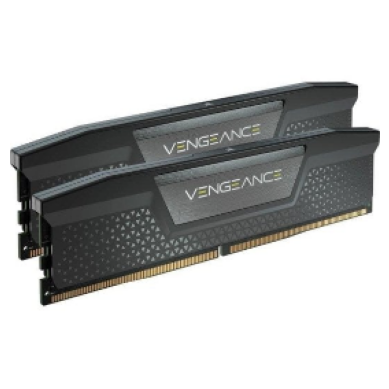

In [34]:
X[0]
img_array = X[0]

# Mostrar
plt.imshow(img_array)
plt.axis("off")
plt.show()

In [35]:
X

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

## Descripción de los datos

El dataset cuenta con  y **2 columnas**, de las cuales `label` es de tipo `int64` e `image` es de tipo `object`, ya que contiene la imagen vectorizada.

| Columna | Tipo   | Descripción                                        |
| ------- | ------ | -------------------------------------------------- |
| image   | object | Imagen vectorizada del componente de computadora   |
| label   | int64  | Etiqueta numérica que indica el tipo de componente |

El **target** que se busca predecir es el **label**, es decir, el tipo de componente.

| Número | Componente     |
| ------ | -------------- |
| 0      | motherboard    |
| 1      | gpu            |
| 2      | cpu            |
| 3      | hard_drive     |
| 4      | ram            |
| 5      | pc_case        |
| 6      | power_supply   |
| 7      | liquid_cooling |
| 8      | case_fan       |
| 9      | cpu_fan        |
| 10     | sound_card     |



<!-- {0: 'motherboard', 1: 'gpu', 2: 'cpu', 3: 'hard_drive', 4: 'ram', 5: 'pc_case', 6: 'power_supply', 7: 'liquid_cooling', 8: 'case_fan', 9: 'cpu_fan', 10: 'sound_card'} -->


## Exploración y visualización de los datos

Se realizará un estudio de los datos mostrando gráficas, observando si hay valores nulos, etc.

### Tipos de componentes:

| Número | Componente     |
| ------ | -------------- |
| 0      | motherboard    |
| 1      | gpu            |
| 2      | cpu            |
| 3      | hard_drive     |
| 4      | ram            |
| 5      | pc_case        |
| 6      | power_supply   |
| 7      | liquid_cooling |
| 8      | case_fan       |
| 9      | cpu_fan        |
| 10     | sound_card     |


In [36]:
label_map = {
    0: 'motherboard',
    1: 'gpu',
    2: 'cpu',
    3: 'hard_drive',
    4: 'ram',
    5: 'pc_case',
    6: 'power_supply',
    7: 'liquid_cooling',
    8: 'case_fan',
    9: 'cpu_fan',
    10: 'sound_card'
}

### Distribución de imágenes por tipo de componente

En nuestro conjunto de casi 10,000 imágenes, la distribución por tipo de componente muestra una variedad relativamente equilibrada entre varias categorías, aunque con algunas diferencias destacables. Por ejemplo, los componentes como el **disco duro** y la **caja del PC** representan una proporción considerablemente mayor (19.0% y 18.3%, respectivamente), mientras que otros como la **tarjeta de sonido** apenas alcanzan el 0.5%.  

Estas variaciones reflejan una presencia más frecuente de ciertos componentes en el conjunto de datos, lo que está relacionado con su disponibilidad visual o relevancia técnica.



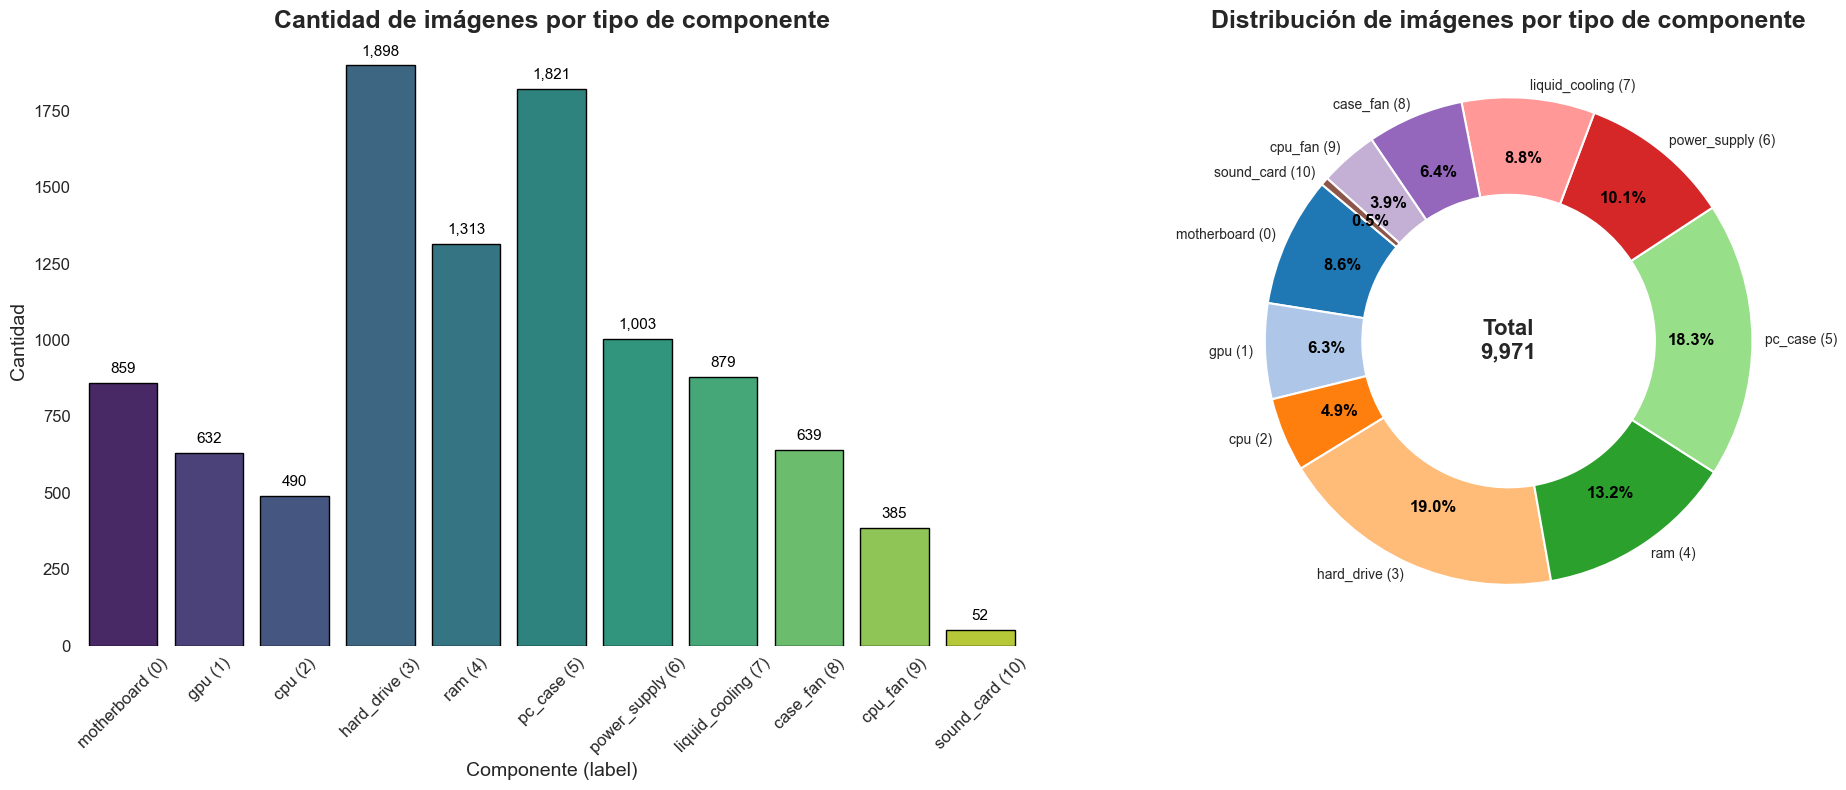

In [37]:
label_counts = df["label"].value_counts().sort_index().reset_index()
label_counts.columns = ["label", "count"]
label_counts["label_display"] = label_counts["label"].map(label_map) + " (" + label_counts["label"].astype(str) + ")"

labels = label_counts["label_display"]
sizes = label_counts["count"]
total_images = sizes.sum()
colors = plt.cm.tab20.colors[:len(labels)]

sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

barplot = sns.barplot(
    x="label_display",
    y="count",
    data=label_counts,
    hue="label_display",
    palette="viridis",
    edgecolor="black",
    legend=False,
    ax=axes[0]
)

for patch in barplot.patches:
    height = patch.get_height()
    barplot.annotate(
        f"{int(height):,}",
        (patch.get_x() + patch.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=11,
        color="black",
        xytext=(0, 5),
        textcoords="offset points"
    )

axes[0].set_title("Cantidad de imágenes por tipo de componente", fontsize=18, weight="bold")
axes[0].set_xlabel("Componente (label)", fontsize=14)
axes[0].set_ylabel("Cantidad", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
sns.despine(ax=axes[0], left=True, bottom=True)

wedges, texts, autotexts = axes[1].pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={"width":0.4, "edgecolor":"white", "linewidth":1.5},
    pctdistance=0.75,
    labeldistance=1.05
)

for autotext in autotexts:
    autotext.set_color("black")
    autotext.set_fontsize(12)
    autotext.set_weight("bold")

axes[1].text(0, 0, f"Total\n{total_images:,}", ha="center", va="center", fontsize=16, weight="bold")
axes[1].set_aspect("equal")
axes[1].set_title("Distribución de imágenes por tipo de componente", fontsize=18, weight="bold")

plt.tight_layout()
plt.show()


### Visualización de imágenes

Vamos a visualizar algunas imágenes para ver cómo están guardadas y cómo se verían.


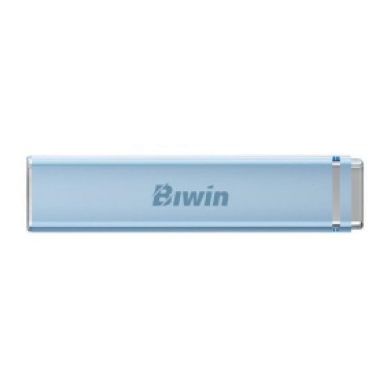

In [38]:
# Mostrar
plt.imshow(X[1])
plt.axis("off")
plt.show()

In [39]:
X_train_full, y_train_full, X_test, y_test = X[:8000], y[:8000], X[8000:], y[8000:]

In [40]:
X_train_full = X_train_full.astype('float32') / 255.0

In [41]:
X_test = X_test.astype('float32') / 255.0

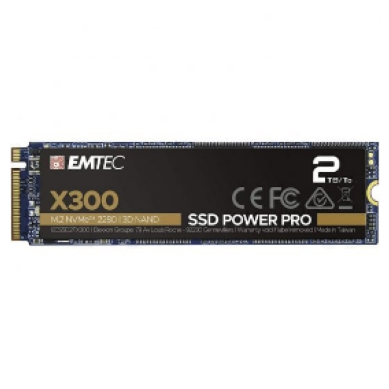

In [42]:
plt.imshow(X_train_full[344])
plt.axis("off")
plt.show()

In [43]:
X_valid, X_train = X_train_full[:1000], X_train_full[1000:]

In [51]:
y_valid, y_train = y_train_full[:1000], y_train_full[1000:]

In [53]:
model = keras.models.Sequential()

In [54]:
model.add(keras.layers.Flatten(input_shape=[270, 270, 3]))

c:\Users\ALVARO\Desktop\HardVisionAI\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
model.add(keras.layers.Dense(50, activation="sigmoid"))

In [57]:
model.add(keras.layers.Dense(120, activation="relu"))

In [58]:
model.add(keras.layers.Dense(11, activation="softmax"))

In [59]:
# Resumen del modelo
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 218700)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │    10,935,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │         6,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 11)             │         1,331 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,942,501 (41.74 MB)

 Trainable params: 10,942,501 (41.74 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [61]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.2870 - loss: 2.0369 - val_accuracy: 0.3310 - val_loss: 1.8962
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.3503 - loss: 1.8192 - val_accuracy: 0.3970 - val_loss: 1.7629
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.3980 - loss: 1.7012 - val_accuracy: 0.4640 - val_loss: 1.6076
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.4424 - loss: 1.6162 - val_accuracy: 0.4760 - val_loss: 1.5599
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.4594 - loss: 1.5751 - val_accuracy: 0.5560 - val_loss: 1.4890
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.4871 - loss: 1.5259 - val_accuracy: 0.4770 - val_loss: 1.5065
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.5060 - loss: 1.4932 - val_accuracy: 0.4540 - val_loss: 1.5772
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.5180 - loss: 1.4970 - 

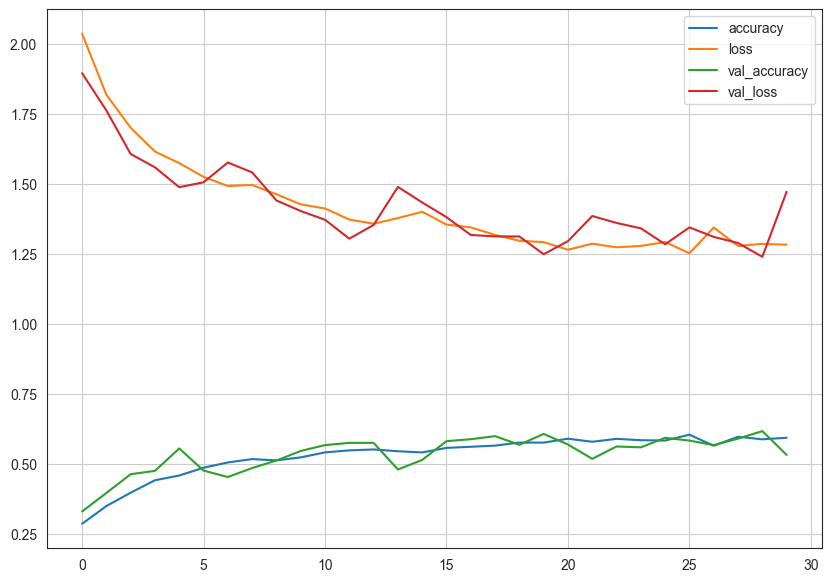

In [62]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid()
plt.show()

In [63]:
model.evaluate(X_test, y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5266 - loss: 1.4996


[1.4996178150177002, 0.5266362428665161]

In [72]:
X_new = X_test[:6]
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [65]:
y_pred

array([[1.9009556e-03, 2.9812348e-01, 1.1002890e-02, 1.3758349e-01,
        1.0608894e-02, 6.1620545e-02, 9.6025884e-02, 7.7627085e-02,
        1.3588266e-01, 1.6376156e-01, 5.8625164e-03],
       [3.3785135e-02, 9.6430674e-02, 1.3787183e-02, 5.5387568e-02,
        2.7438366e-01, 8.1040770e-02, 7.9868838e-02, 2.0017107e-01,
        9.9568531e-02, 5.2884251e-02, 1.2692328e-02],
       [3.5735071e-03, 4.1237790e-02, 5.8920583e-04, 3.3091996e-02,
        9.2118913e-03, 2.0478997e-02, 8.2232583e-01, 2.4558602e-02,
        8.7914523e-03, 3.2817967e-02, 3.3227880e-03]], dtype=float32)

In [73]:
y_pred = np.argmax(y_pred, axis=1)

In [74]:
y_pred

array([1, 4, 6, 3, 7, 3])

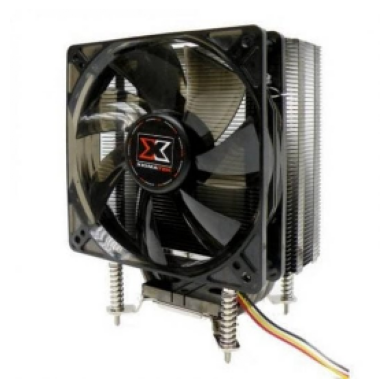

In [69]:
example_cifar5 = X_new[0]
plt.imshow(example_cifar5)
plt.axis("off")
plt.show()

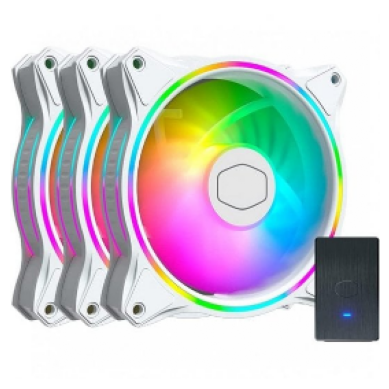

In [70]:
example_cifar5 = X_new[1]
plt.imshow(example_cifar5)
plt.axis("off")
plt.show()

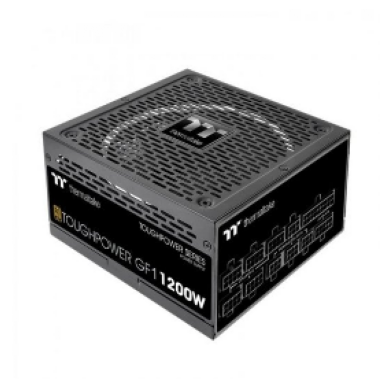

In [71]:
example_cifar5 = X_new[2]
plt.imshow(example_cifar5)
plt.axis("off")
plt.show()

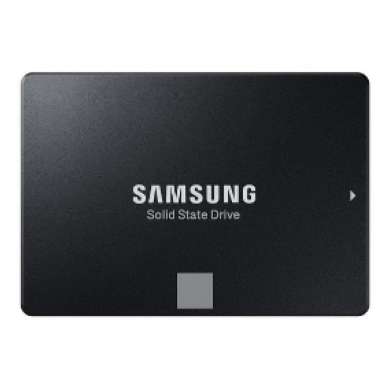

In [75]:
example_cifar5 = X_new[3]
plt.imshow(example_cifar5)
plt.axis("off")
plt.show()

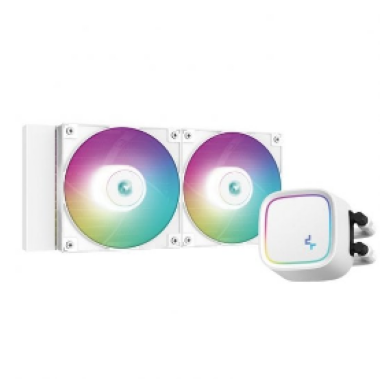

In [76]:
example_cifar5 = X_new[4]
plt.imshow(example_cifar5)
plt.axis("off")
plt.show()

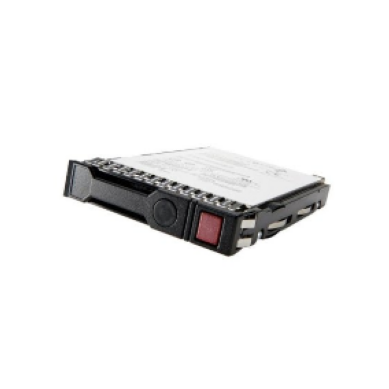

In [77]:
example_cifar5 = X_new[5]
plt.imshow(example_cifar5)
plt.axis("off")
plt.show()